# Import section

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

# Modeling

I have decided too approach the prediction of the rent prices by running regression models. I will create some models and afterwards let them run with different features to find the best result. To keep track of the results I will create an empty dataFrame in which I will save always the results. 

At the end I will take the mean of the cross validated score to estimate the best results. 

In [2]:
#import of the dataframe
df_data = pd.read_csv("../3.EDA/df_data.csv", index_col = 0)

# Final preparation before modeling

## DataFrame for results

To store and compare the results of different models i will create a dataFrame to include the calculated values per model.

In [3]:
df_results = pd.DataFrame(columns=["model_features", "model", "train_score", "cross_validation_score","test_score"])

## Defining target and predictors

I will define the monthly price as target (y) the rest of the dataframe will be the predictors. At a later stage i will also split the predictors again to see if the additional features are showing some impact. While defining the predictors i will drop already some columns which i will not use as predictors for the modeling. These columns are: 
- "price"
- "title" 
- "location"
- "published"

In [5]:
#Split between target and features
y = df_data['price']
X = df_data.drop(columns = ["price","name","location","published"])

## Function for modeling

In a next step I will set up a function which will run through the different models and save the results within the dataframe. 

In [6]:
def evaluation_models(model_features, models, names, 
                x_train, x_test, y_train, y_test): 
    
    """
    Calculates for different models the train score, test score and the mean cross validation
    score. Values are stored within the dataframe "result"
    model_features: Seperation betwenn plain zoopla and zoopla+additional features
    names: List of model names as strings
    models: List of models to test
    x_train, x_test: x values to train and test the model on
    y_train, y_test: y values to train and test the model on
    """
    global df_results
    for model, name in tqdm(list(zip(models, names))): 
        
        # fiting the model
        model.fit(x_train, y_train)
        
        # calculating the different scores
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        cross_vali_score = cross_val_score(model, x_test, y_test, cv=5).mean()
        
        # saving the result in the "results" dataframe
        df_results = df_results.append(
                             {"model_features":model_features,
                              "model":name,
                              "train_score":train_score,
                              "cross_validation_score":cross_vali_score, 
                              "test_score": test_score},
                              ignore_index=True)  

## Defining the models 

The target variable (the rent price) is a continues variable. Because of this i will fit a regression model. In a first instance I will run four different regression models: 
1. basic Linear Regression (without penalties)
2. A regression with Lasso penalty
3. A regression with Ridge penalty
4. An ElasticNet which covers a combination of both penalties (Lasso and Ridge)

The penalties of the lasso and ridge model will reduce the variance but this will also raise the errors/bias. I will use the inbuilt cross validation functions to find the right bias / variance trade-off for the best compromise.

The two different penalties have a different approach. I would like to mention that with the Lasso penalty it is more likely that some of the coefficients will be zero at the end.

In [7]:
# List of model with parameters
models = [LinearRegression(), 
          LassoCV(n_alphas=200, cv=5,max_iter=100000,n_jobs = -1), 
          RidgeCV(alphas = np.logspace(1, 7, 200), cv=5), 
          ElasticNetCV(l1_ratio=[0.01, 0.1, 0.5, 0.7, 0.9, 0.99],
                       alphas=np.logspace(-2, 2, 30), 
                       cv=5, max_iter=120000, n_jobs = -1)]
# List of the names of the models 
names = ['Regular Linear Regression', 'LassoCV', 'RidgeCV', 'ElasticNetCV']

# Modeling on basic Zoopla data with postcode

## Selection of the predictors 

Within my columns i have two ways of describing the location:
1. The postcode which is a little bit more vague
2. The longitude and the latitude of the object. 
    
Within the EDA section i realized that the longitude and latitude has no big correlation with the price. but further analysis showed that the location has a big impact on it. Because of this i would like to run some models separate once taking the postcode into consideration and once taking the longitude and latitude. Additional to the two different location features i will use the following information which are directly available on zoopla:

- Amount of Bedrooms
- Amount of Bathrooms
- Amount of Receptions
- Close by Public transport stations 

In [8]:
#first i will define the predictors
X_zop_postcode = X.drop(columns = ["longitude", "latitude", "tesco", "marks_and_Spencer","sainsbury", "whole_foods",
                                   "nr_pb_trans", "nr_gym"])

The postcode column only includes strings with the postcode for each object. To make it usable for the modeling i will dummify it into binary values for each postcode

In [9]:
df_temp_postcode = pd.get_dummies(X_zop_postcode["postcode"])
X_zop_postcode = pd.concat([X_zop_postcode, df_temp_postcode], axis = 1)
X_zop_postcode.drop(columns = ["postcode"], inplace = True)

In [10]:
print(X_zop_postcode.shape)

(65777, 870)


## Scaling of the predictors

I will perform a transformation with a standard scaler on the train set and test set.

In [11]:
scaler = StandardScaler()
X_zop_postcode = pd.DataFrame(scaler.fit_transform(X_zop_postcode), columns=X_zop_postcode.columns)

## Train-test Split

I will create a train test split of the data. like his it will be possible to train the model first with the train set and evaluate on the unseen test data. I will use 80% of the data for training and 20% for the testing afterwards.

In [12]:
X_zop_postcode_train, X_zop_postcode_test, y_train, y_test = train_test_split(X_zop_postcode, y, test_size=0.2,
                                                    random_state=42)

## modeling

In [13]:
evaluation_models("zoopla (postcode)", models, names, X_zop_postcode_train, X_zop_postcode_test, y_train, y_test)

100%|███████████████████████████████████████| 4/4 [2:15:36<00:00, 2034.22s/it]


In [18]:
df_results.sort_values("cross_validation_score", ascending = False)

,model_features,model,train_score,cross_validation_score,test_score
2,zoopla (postcode),RidgeCV,0.607221,5.882763e-01,0.603879
3,zoopla (postcode),ElasticNetCV,0.606923,5.879557e-01,0.603873
1,zoopla (postcode),LassoCV,0.604284,5.860558e-01,0.602908
0,zoopla (postcode),Regular Linear Regression,0.608940,-7.845481e+22,0.602947


I will evaluate the model based on the cross validation score. For the first input the ridgeCV model shows the best result. Before further investigations i will have a look at the results when i am using the coordinates instead of the postcodes. 

# Modeling on basic Zoopla data with coordinates

## Selection of the predictors 

This time instead of the postcode i will use the longitude and latitude together with the other predictors. 

In [14]:
#first i will define the predictors
X_zop_cor= X.drop(columns = ["postcode", "tesco", "marks_and_Spencer","sainsbury", "whole_foods",
                                   "nr_pb_trans", "nr_gym"])

## Scaling of the predictors

In [15]:
scaler = StandardScaler()
X_zop_cor = pd.DataFrame(scaler.fit_transform(X_zop_cor), columns=X_zop_cor.columns)

## Train-test Split

In [16]:
X_zop_cor_train, X_zop_cor_test, y_train, y_test = train_test_split(X_zop_cor, y, test_size=0.2,
                                                    random_state=42)

## modeling

In [17]:
evaluation_models("zoopla (coordinates)", models, names, X_zop_cor_train, X_zop_cor_test, y_train, y_test)

100%|███████████████████████████████████████| 4/4 [1:58:24<00:00, 1776.06s/it]


In [24]:
df_results.sort_values("cross_validation_score", ascending = False)

,model_features,model,train_score,cross_validation_score,test_score
2,zoopla (postcode),RidgeCV,0.607221,5.882763e-01,0.603879
3,zoopla (postcode),ElasticNetCV,0.606923,5.879557e-01,0.603873
1,zoopla (postcode),LassoCV,0.604284,5.860558e-01,0.602908
7,zoopla (coordinates),ElasticNetCV,0.424933,4.091262e-01,0.421075
6,zoopla (coordinates),RidgeCV,0.425246,4.090916e-01,0.421148
5,zoopla (coordinates),LassoCV,0.421453,4.086997e-01,0.418706
4,zoopla (coordinates),Regular Linear Regression,0.426865,-1.106234e+21,0.420135
0,zoopla (postcode),Regular Linear Regression,0.608940,-7.845481e+22,0.602947


Looking at the results i can see that the models using the postcode performed much better. Again the RidgeCV is the best one. I will have a this model combined with the features including the postcode. 

## Evaluating best model 

In [18]:
ridge = RidgeCV(alphas = np.logspace(1, 7, 200), cv=5)
ridge.fit(X_zop_postcode_train, y_train)

RidgeCV(alphas=array([1.00000000e+01, 1.07189132e+01, 1.14895100e+01, 1.23155060e+01,
       1.32008840e+01, 1.41499130e+01, 1.51671689e+01, 1.62575567e+01,
       1.74263339e+01, 1.86791360e+01, 2.00220037e+01, 2.14614120e+01,
       2.30043012e+01, 2.46581108e+01, 2.64308149e+01, 2.83309610e+01,
       3.03677112e+01, 3.25508860e+01, 3.48910121e+01, 3.73993730e+01,
       4.00880633e+01, 4.29700470e+0...
       2.02550194e+06, 2.17111795e+06, 2.32720248e+06, 2.49450814e+06,
       2.67384162e+06, 2.86606762e+06, 3.07211300e+06, 3.29297126e+06,
       3.52970730e+06, 3.78346262e+06, 4.05546074e+06, 4.34701316e+06,
       4.65952567e+06, 4.99450512e+06, 5.35356668e+06, 5.73844165e+06,
       6.15098579e+06, 6.59318827e+06, 7.06718127e+06, 7.57525026e+06,
       8.11984499e+06, 8.70359136e+06, 9.32930403e+06, 1.00000000e+07]),
        cv=5)

In [19]:
print('Alpha: ', ridge.alpha_) 
print('Intercept: ', ridge.intercept_)

Alpha:  160.70528182616385
Intercept:  1905.5342996796276


In [20]:
ridge_coefs = pd.DataFrame(list(zip(X_zop_postcode_train.columns, ridge.coef_, abs(ridge.coef_))), 
             columns = ['Feature', 'Coef', 'Abs_coef']).sort_values(
             by='Abs_coef', ascending=False)

In [21]:
ridge_coefs.head(10)

,Feature,Coef,Abs_coef
0,bedrooms,378.419801,378.419801
1,bathrooms,144.319198,144.319198
126,Clapham South,-139.571132,139.571132
36,Battersea Park,137.971400,137.971400
49,Belsize Park,-137.050198,137.050198
857,W2,128.119936,128.119936
819,SW3,112.354665,112.354665
250,Harringay,-110.660032,110.660032
850,W1,105.333955,105.333955
444,Reedham,-101.390056,101.390056


The result is showing that the highest impact is coming from the amount of bedrooms(1). Also bathrooms(5) are higher listed. Otherwise tube and train stations are showing up at higher positions.

### Plotting predictions vs. acctual values

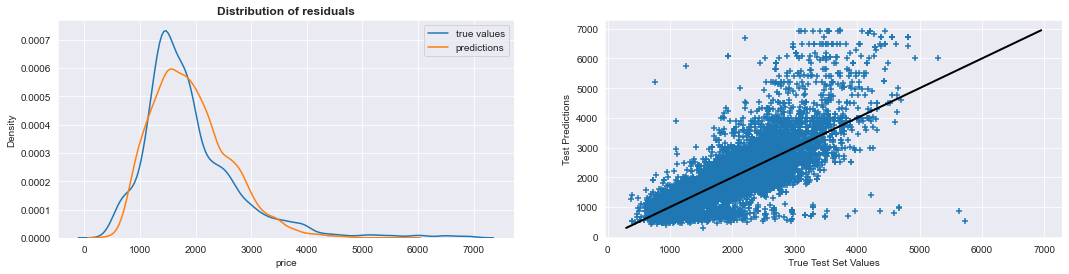

In [22]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(ncols=2, figsize=(18,4))
x = np.linspace(-4,  4, 100)

sns.kdeplot(y_test, label='true values', ax=ax[0])
sns.kdeplot(ridge.predict(X_zop_postcode_test), label='predictions',ax=ax[0] )
ax[0].set_title('Distribution of residuals', fontweight='bold')
ax[0].legend()

point_1 = [y_test.min(), y_test.max()]
ax[1].plot(point_1, point_1, c='k', lw=2)
ax[1].scatter(ridge.predict(X_zop_postcode_test), y_test,marker='+')
ax[1].set_xlabel("True Test Set Values")
ax[1].set_ylabel("Test Predictions")
plt.show()

### Calculating the residuals 

In [23]:
residuals_ridgecv_zoop = y_test - ridge.predict(X_zop_postcode_test)

/Users/johannesebert/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


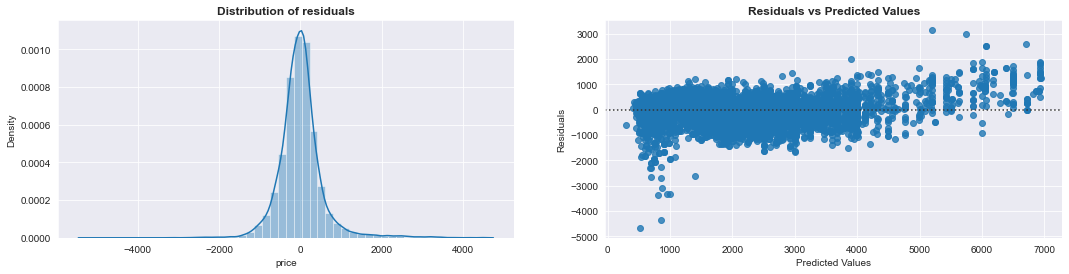

In [24]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(ncols=2, figsize=(18,4))
x = np.linspace(-4,  4, 100)

sns.distplot(residuals_ridgecv_zoop, label='residuals', ax=ax[0])
ax[0].set_title('Distribution of residuals', fontweight='bold')

sns.residplot(x=y_test, y=residuals_ridgecv_zoop ,ax=ax[1])
ax[1].set_title('Residuals vs Predicted Values', fontweight='bold')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel("Residuals")
plt.show()

plt.show()

The residuals are randomly distributed (there is no clear pattern in the plot above), which tells us that the (linear) model chosen is not bad, but there are too many high values of the residuals  which means that the errors of the model are high.

# Modeling on full data set 

## Selection of the predictors 

The above models showed that the postcode as location will bring much better result than the coordinates. Now i will run the models again and include the additional features to see if they will increase the score. I will only include the postcode and exclude the longitude and latitude for the location. 
    
    

In [25]:
X_all = X.drop(columns = ["longitude", "latitude"])

The postcode column only includes strings with the postcode for each object. To make it usable for the modeling i will dummify it into binary values for each postcode

In [26]:
df_temp_postcode = pd.get_dummies(X_all["postcode"])
X_all = pd.concat([X_all, df_temp_postcode], axis = 1)
X_all.drop(columns = ["postcode"], inplace = True)

In [27]:
print(X_all.shape)

(65777, 876)


## Scaling of the predictors

In [28]:
scaler = StandardScaler()
X_all = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)

## Train-test Split

In [29]:
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2,
                                                    random_state=42)

## modeling

In [30]:
evaluation_models("complete data", models, names, X_all_train, X_all_test, y_train, y_test)

100%|███████████████████████████████████████| 4/4 [3:02:52<00:00, 2743.13s/it]


In [32]:
df_results.sort_values("cross_validation_score", ascending = False).head(10)

,model_features,model,train_score,cross_validation_score,test_score
10,complete data,RidgeCV,0.619214,5.983459e-01,6.125033e-01
11,complete data,ElasticNetCV,0.618832,5.981247e-01,6.123726e-01
9,complete data,LassoCV,0.616107,5.976267e-01,6.105827e-01
2,zoopla (postcode),RidgeCV,0.617291,5.963651e-01,6.103617e-01
3,zoopla (postcode),ElasticNetCV,0.616877,5.961016e-01,6.101651e-01
1,zoopla (postcode),LassoCV,0.614283,5.952881e-01,6.085248e-01
7,zoopla (coordinates),ElasticNetCV,0.431714,4.058728e-01,4.180429e-01
6,zoopla (coordinates),RidgeCV,0.432073,4.057913e-01,4.181559e-01
5,zoopla (coordinates),LassoCV,0.428224,4.041489e-01,4.159164e-01
8,complete data,Regular Linear Regression,0.620117,-1.713636e+19,-9.059117e+18


The complete date together with the ridge model is showing the best score. But the increase of the mean cv score is not very high. Our additional feature did not bring a big effect. Nevertheless i would like to have a closer look at the coefficients of the features: 

In [33]:
ridge_all = RidgeCV(alphas = np.logspace(1, 7, 200), cv=5)
ridge_all.fit(X_all_train, y_train)
ridge_coefs_all = pd.DataFrame(list(zip(X_all_train.columns, ridge_all.coef_, abs(ridge_all.coef_))), 
             columns = ['Feature', 'Coef', 'Abs_coef']).sort_values(
             by='Abs_coef', ascending=False)

In [34]:
ridge_coefs_all = pd.DataFrame(list(zip(X_all_train.columns, ridge_all.coef_, abs(ridge_all.coef_))), 
             columns = ['Feature', 'Coef', 'Abs_coef']).sort_values(
             by='Abs_coef', ascending=False)
ridge_coefs_all.reset_index(drop=True, inplace=True)
ridge_coefs_all.head(10)

,Feature,Coef,Abs_coef
0,bedrooms,379.997042,379.997042
1,bathrooms,144.037687,144.037687
2,Belsize Park,-138.475291,138.475291
3,Battersea Park,136.436256,136.436256
4,Clapham South,-135.757310,135.757310
5,W2,120.171790,120.171790
6,SW3,108.429489,108.429489
7,Harringay,-108.028851,108.028851
8,Reedham,-94.044992,94.044992
9,Blackhorse Lane,89.760196,89.760196


I would like to see at which position are the additional features ranked within the model.

In [147]:
add_features = ["tesco", "marks_and_Spencer","sainsbury", "whole_foods",
                    "nr_pb_trans", "nr_gym"]

In [148]:
ridge_coefs_all[ridge_coefs_all["Feature"].isin(add_features)]

,Feature,Coef,Abs_coef
120,tesco,37.570791,37.570791
246,nr_gym,23.606961,23.606961
302,sainsbury,19.817684,19.817684
359,marks_and_Spencer,17.411138,17.411138
464,whole_foods,-13.097705,13.097705
651,nr_pb_trans,6.049188,6.049188


Based on the index number I can see that the coefficients have not a big impact. The highest impact has a close by tesco. Surprisingly whole foods has even a bad impact on the price. This surprised me as i thought that this would have a positive impact as this is a supermarket with a higher price category. 

# Further Analysis of the features with Statsmodels 

For further investigation of coefficient i would like to use statsmodels. First i will run the model with ols() which is the Ordinary Least Squares function from the statsmodels library. In brief, it compares the difference between individual points in the data set and the predicted best fit line to measure the amount of error produced. It requires two inputs, the formula for producing the best fit line, and the dataset.

In [35]:
stats_model = sm.OLS(y_train, sm.add_constant(X_all_train))
results = stats_model.fit()

predictions_stats = results.predict(sm.add_constant(X_all_train))
print("R2-score: ", results.rsquared)
print("RMSE:", np.sqrt(mean_squared_error(y_train, predictions_stats)))

/Users/johannesebert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


R2-score:  0.6201169011683021
RMSE: 545.3215655742376


The R2-score is showing a result of 0.62011 which means our model can more or less only explain 62% of the targets. 

Afterwards I will rerun the model and regularize it in form of an elastic net, allowing to reduce the model to either Lasso or Ridge.

In [36]:
results_reg = stats_model.fit_regularized(alpha=0.05, L1_wt=0.1, refit=True)
predictions_stats = results_reg.predict(sm.add_constant(X_all_train))
print("R2-score: ", results_reg.rsquared)
print("RMSE:", np.sqrt(mean_squared_error(y_train, predictions_stats)))

/Users/johannesebert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


R2-score:  0.6199191315314374
RMSE: 545.4634960988935


The below summary overview is giving information about the model which will help to interpret the results.

DF Model: Shows us how many features from the model have been taken into consideration for the calculation.
I will more focus on the section showing the parameters for each feature:

coef: shows the coefficient of each feature, it is the measurement of how change in that variable affects the independent variable.
std: shows standard deviation of the coefficient, a measurement of the amount of variation in the coefficient throughout its data points.
t: The t is related and is a measurement of the precision with which the coefficient was measured. A low std error compared to a high coefficient produces a high t statistic, which signifies a high significance for your coefficient.
P>|t| is one of the most important statistics in the summary. It uses the t statistic to produce the p value, a measurement of how likely your coefficient is measured through our model by chance. The p value is saying there is a x% chance the variable has no affect on the dependent variable. This means the higher this value the more likely the variable has no impact.
looking at this p value i would like to adjust my features and drop some of them which are not giving a high impact.

In [37]:
results_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     97.70
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        09:33:15   Log-Likelihood:            -4.0626e+05
No. Observations:               52621   AIC:                         8.143e+05
Df Residuals:                   51757   BIC:                         8.219e+05
Df Model:                         864                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
bedrooms                                              381.7011      2.864    133.270      0.000     376.087     387.315
bathrooms                                             143.6157      2.787     51.522      0.000     138.152     149.079
receptions                                             88.8009      2.562     34.661      0.000      83.779      93.822
nr_pb_trans                                         -1145.0186    287.512     -3.983      0.000   -1708.545    -581.492
nr_gym                                                 21.6540      4.992      4.338      0.000      11.871      31.437
tesco                                                  41.7954      4.158     10.052      0.000      33.646      49.945
marks_and_Spencer                                      19.4573      3.582      5.432      0.000      12.436      26.478
sainsbury                                              15.7016      3.605      4.356      0.000       8.637      22.767
whole_foods                                           -17.0314      3.241     -5.255      0.000     -23.384     -10.679
Abbey Road                                             31.5973     19.427      1.626      0.104      -6.480      69.675
Abbey Wood                                             -5.3805      6.010     -0.895      0.371     -17.161       6.400
Acton Central                                           0.5188     12.106      0.043      0.966     -23.209      24.246
Acton Main Line                                        14.2820     31.719      0.450      0.653     -47.888      76.452
Acton Town                                              2.4958     11.308      0.221      0.825     -19.668      24.660
Addington Village                                      -4.2663     17.855     -0.239      0.811     -39.262      30.730
Addiscombe                                             32.6153     22.387      1.457      0.145     -11.263      76.493
Albany Park                                            22.5758     11.621      1.943      0.052      -0.202      45.354
Aldgate                                               -28.6686     38.995     -0.735      0.462    -105.100      47.763
Aldgate East                                           -0.8161     24.675     -0.033      0.974     -49.178      47.546
Alexandra Palace                                       39.3576     22.436      1.754      0.079      -4.618      83.333
All Saints                                            -44.9365     26.905     -1.670      0.095     -97.671       7.798
Alperton                                               26.4784     12.101      2.188      0.029       2.760      50.197
Ampere Way                                            136.5193     24.384      5.59

Looking at the summary i especially want to have a look at the results for the additional values:
- nr_pb_trans: Shows a very high p-value. This means it is very likely that the feature has no impact. 
- nr_of_gyms: shows a p-value of zero so apparently it has an impact.
- supermarkets: for all supermarket related features the overview is also showing zero so also here an impact is very likely. 

But as we saw above the impact seems not to be very much. 

# additional models 

## KNeighborsRegressor

In [38]:
for i in range(3,12):
    names = [f'KNeighborsRegressor {i+1}']
    knn = [KNeighborsRegressor(n_neighbors=(i+1), n_jobs=-1)]
    evaluation_models("complete data",knn, names, X_all_train, X_all_test, y_train, y_test)

100%|██████████████████████████████████████████████| 1/1 [03:17<00:00, 197.31s/it]


In [39]:
df_results.sort_values("cross_validation_score", ascending = False).head(10)

,model_features,model,train_score,cross_validation_score,test_score
10,complete data,RidgeCV,0.619214,0.598346,0.612503
11,complete data,ElasticNetCV,0.618832,0.598125,0.612373
9,complete data,LassoCV,0.616107,0.597627,0.610583
2,zoopla (postcode),RidgeCV,0.617291,0.596365,0.610362
3,zoopla (postcode),ElasticNetCV,0.616877,0.596102,0.610165
1,zoopla (postcode),LassoCV,0.614283,0.595288,0.608525
7,zoopla (coordinates),ElasticNetCV,0.431714,0.405873,0.418043
6,zoopla (coordinates),RidgeCV,0.432073,0.405791,0.418156
12,complete data,KNeighborsRegressor 4,0.819997,0.405389,0.682999
5,zoopla (coordinates),LassoCV,0.428224,0.404149,0.415916


The KNeighborsRegressor didn't perform very well. It has a high train and test score but the cross validated scores are very low. 

## DecisionTreeRegressor

In [40]:
for i in range(10): 
    names = [f'Decision Tree Regressor {i+1}']
    dt = [DecisionTreeRegressor(max_depth=(i+1), random_state=42)]
    print('max_depth = {}'.format(i+1))
    evaluation_models("complete data", dt, names, X_all_train, X_all_test, y_train, y_test)

max_depth = 1


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


max_depth = 2


100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


max_depth = 3


100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


max_depth = 4


100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


max_depth = 5


100%|███████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


max_depth = 6


100%|███████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


max_depth = 7


100%|███████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


max_depth = 8


100%|███████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]


max_depth = 9


100%|███████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]


max_depth = 10


100%|███████████████████████████████████████████████| 1/1 [00:04<00:00,  4.14s/it]


In [40]:
df_results.sort_values("cross_validation_score", ascending = False).head(10)

,model_features,model,train_score,cross_validation_score,test_score
11,complete data,RidgeCV,0.608725,0.589030,0.605179
12,complete data,ElasticNetCV,0.608429,0.588563,0.605157
2,zoopla (postcode),RidgeCV,0.607221,0.588276,0.603879
3,zoopla (postcode),ElasticNetCV,0.606923,0.587956,0.603873
10,complete data,LassoCV,0.605733,0.586705,0.604024
1,zoopla (postcode),LassoCV,0.604284,0.586056,0.602908
30,complete data,Decision Tree Regressor 9,0.658602,0.536873,0.607005
31,complete data,Decision Tree Regressor 10,0.691655,0.535781,0.644795
29,complete data,Decision Tree Regressor 8,0.622972,0.515712,0.582864
28,complete data,Decision Tree Regressor 7,0.584948,0.509564,0.549325


Also the decision tree didn't perform better than the ridge model on the complete data. But it performed much better than the KNeighborsRegressor.

## RandomForestRegressor

In [41]:
for i in range(5,15): 
    names = [f'RandomForestRegressor {i}']
    rf = [RandomForestRegressor(max_depth=(i+1), random_state=42, n_jobs=-1)]
    print('max_depth = {}'.format(i+1))
    evaluation_models("complete data",rf, names, X_all_train, X_all_test, y_train, y_test)

max_depth = 6


100%|███████████████████████████████████████████| 1/1 [01:03<00:00, 63.84s/it]


max_depth = 7


100%|███████████████████████████████████████████| 1/1 [01:14<00:00, 74.39s/it]


max_depth = 8


100%|███████████████████████████████████████████| 1/1 [01:25<00:00, 85.33s/it]


max_depth = 9


100%|███████████████████████████████████████████| 1/1 [01:37<00:00, 97.42s/it]


max_depth = 10


100%|██████████████████████████████████████████| 1/1 [01:44<00:00, 104.61s/it]


max_depth = 11


100%|██████████████████████████████████████████| 1/1 [01:54<00:00, 114.21s/it]


max_depth = 12


100%|██████████████████████████████████████████| 1/1 [02:03<00:00, 123.22s/it]


max_depth = 13


100%|██████████████████████████████████████████| 1/1 [02:13<00:00, 133.13s/it]


max_depth = 14


100%|██████████████████████████████████████████| 1/1 [02:20<00:00, 140.34s/it]


max_depth = 15


100%|██████████████████████████████████████████| 1/1 [02:27<00:00, 147.88s/it]


In [42]:
df_results.sort_values("cross_validation_score", ascending = False).head(10)

,model_features,model,train_score,cross_validation_score,test_score
41,complete data,RandomForestRegressor 14,0.835005,0.670123,0.757509
40,complete data,RandomForestRegressor 13,0.819692,0.666122,0.745991
39,complete data,RandomForestRegressor 12,0.801368,0.659480,0.732147
38,complete data,RandomForestRegressor 11,0.779724,0.652584,0.715559
37,complete data,RandomForestRegressor 10,0.754444,0.644399,0.695935
36,complete data,RandomForestRegressor 9,0.725232,0.632302,0.673310
35,complete data,RandomForestRegressor 8,0.692244,0.618355,0.649076
34,complete data,RandomForestRegressor 7,0.654059,0.601718,0.619543
11,complete data,RidgeCV,0.608725,0.589030,0.605179
12,complete data,ElasticNetCV,0.608429,0.588563,0.605157


Surprisingly the random forest performed very good. Train score, test score and cross validation score are higher compared to the other models. This is very surprising for me and i want to have a closer look. 

First i will have a look at the feature importance. 

In [42]:
rf_best = RandomForestRegressor(max_depth=14, random_state=42, n_jobs=-1)
rf_best.fit(X_all_train, y_train)
result = permutation_importance(rf_best, X_all_train, y_train, n_repeats=10, random_state=0)

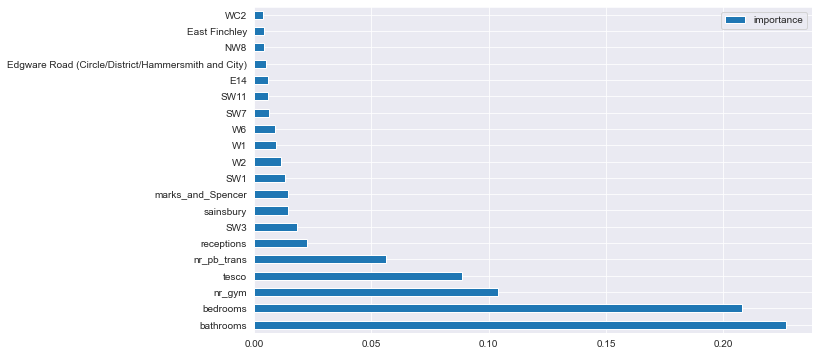

In [43]:
pd.DataFrame(rf_best.feature_importances_,
             columns=['importance'],
             index=X_all_train.columns
             ).sort_values(by='importance', ascending=False
                           ).head(20).plot(kind='barh', figsize=(10, 6))
plt.show()

Surprisingly the random forest regressor shows that additional features like nr_gym and tesco have a high impact on the result. 

The features for internal nodes are selected for regression as variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance.  It is worth to mention, that in this method we should look at relative values of the computed importances. This biggest advantage of this method is a speed of computation - all needed values are computed during the Random Forest training. The drawbacks of the method is to tendency to prefer (select as important) numerical features and categorical features with high cardinality. What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).

In [44]:
#feat_labels= X_all_train.columns[:]
#importances=rf_best.feature_importances_
#indices = np.argsort(importances)[::-1]

I would like to test the feature importance also with the permutation based importance. This can be used to overcome drawbacks of default feature importance computed with mean impurity decrease. As arguments it requires trained model  and validation (test data). This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one.

In [45]:
perm_importance = permutation_importance(rf_best, X_all_test, y_test)

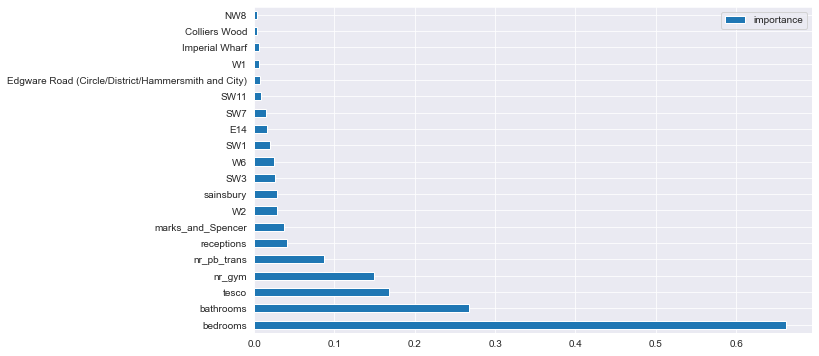

In [47]:
pd.DataFrame(perm_importance.importances_mean,
             columns=['importance'],
             index=X_all_train.columns
             ).sort_values(by='importance', ascending=False).head(20).plot(kind='barh', figsize=(10, 6))
plt.show()                      

Also within this evaluation the nr. of gyms and tesco are showing a higher importance. 

## BaggingRegressor

Bagging is a way to decrease the variance of the prediction model by generating additional data in the training stage. This is produced by random sampling with replacement from the original set. By sampling with replacement, some observations may be repeated in each new training data set. In the case of Bagging, every element has the same probability to appear in a new dataset. By increasing the size of the training set, the model’s predictive force can’t be improved. It decreases the variance and narrowly tunes the prediction to an expected outcome.

These multisets of data are used to train multiple models. As a result, we end up with an ensemble of different models. The average of all the predictions from different models is used. This is more robust than a model. Prediction can be the average of all the predictions given by the different models in case of regression.

For example, Decision tree models tend to have a high variance. Hence, we apply bagging to them. Usually, the Random Forest model is used for this purpose. It is an extension over-bagging. It takes the random selection of features rather than using all features to grow trees. When you have many random trees. It’s called Random Forest. 

In [48]:
model_BG = BaggingRegressor(random_state=42)
model_params = {'n_estimators': [10, 16, 20, 25, 30], 
                'max_samples': [0.6, 0.7, 0.8, 0.9, 1], 
                'max_features': [0.6, 0.7, 0.8, 0.9, 1]}

In [49]:
gs = GridSearchCV(model_BG, model_params, verbose=1, cv=5, n_jobs=3)

In [50]:
gs.fit(X_all_train, y_train.ravel())

Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=42), n_jobs=3,
             param_grid={'max_features': [0.6, 0.7, 0.8, 0.9, 1],
                         'max_samples': [0.6, 0.7, 0.8, 0.9, 1],
                         'n_estimators': [10, 16, 20, 25, 30]},
             verbose=1)

In [51]:
gs.best_score_

0.8350054750517127

In [52]:
best_model = gs.best_estimator_

In [53]:
best_model.get_params

<bound method BaseEstimator.get_params of BaggingRegressor(max_features=0.9, max_samples=0.9, n_estimators=30,
                 random_state=42)>

In [54]:
best_model.score(X_all_test, y_test)

0.8495616427750465

The score is actually very good, but because it is a black-box model (i.e. we cannot tell exactly which features have influenced the modeling decisions), I won't investigate further. The aim of this model is to inform policy decisions, being able to interpret the model is a crucial component of judging its value.

Also the Random forest is a kind of bagging technique and this we evaluated already in more details